# To Create CNN model classifying cats and dogs.

1) Creating Model
2) Image Manipulation
3) Improving Model. (use CAM)
4) Good explainability

---

# Importing Necessary Modules:

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# NN building tools:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Image Manipulation Tools (Data Augmentation):
from keras.preprocessing.image import ImageDataGenerator

# Tools for adding checkpoints:
from keras.callbacks import ModelCheckpoint

import tensorflow as tf

In [ ]:
# %reset -f out

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# Defining Constants / parameters : 

In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
NUM_CHANNELS = 3   # 3 channels - coloured images 
NUM_CLASSES = 2    # 2 classes - cats & dogs
BATCH_SIZE = 32
EPOCHS = 50

# Loading DATA:

In [4]:
def load_data(directory, label):
    imgs = []
    for file in os.listdir(directory):
        path = os.path.join(directory, file)
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        imgs.append([img, label])
    return imgs

In [5]:
# Assigning path to dataset
cats_path = './dataset/cats_and_dogs/0_cats'
dogs_path = './dataset/cats_and_dogs/1_dogs'

In [6]:
# test only:
tmp = cv2.imread(os.path.join(cats_path, '0_003.jpg'))
#plt.imshow(tmp)

### Fetching Images and Labeling:
- 0 - cat
- 1 - dog

In [7]:
cats_data = load_data(cats_path, 0)
dogs_data = load_data(dogs_path, 1)

In [8]:
len(cats_data)

3000

In [9]:
len(dogs_data)

3000

### Combining Data, Shuffling data and converting to appropriate kind:

In [10]:
data = cats_data + dogs_data
len(data)

6000

In [11]:
# Shuffling
np.random.seed(30)
np.random.shuffle(data)

In [12]:
# Converting to Array:
X = []
y = []
for img, label in data:
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [13]:
X.shape

(6000, 128, 128, 3)

## Image data Preprocessing:

In [14]:
def preprocess_data(img_data):

    # Normalising to scale: 0-1
    img_data = img_data.astype('float32')
    img_data /= 255.0 

    # More Preprocessing can be done as per the requirements like Greyscaling (to reduce computational cost)
    # here We will keep colored images only (for better accuracy)
    
    return img_data

In [15]:
X = preprocess_data(X)

In [16]:
#X

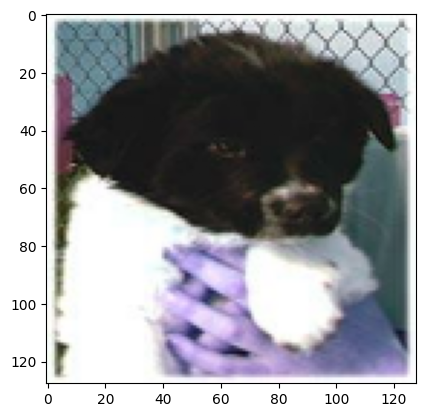

In [17]:
plt.imshow(X[0])

## TRAIN, TEST Data splitting:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [19]:
len(X_train)

4800

---

# IMAGE MANIPULATION:

-  It refers to Image Processing, like we can adjust brightness, color adjustment, etc if required.
-  Also we can perform **DATA AUGMENTATION** using ImageDataGenerator that can generate the versions of images (like flipped, rotated, shifted, etc) : **This also helps in improving the model**

In [242]:
# CAN BOOST our CNN model by using such techniques:
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
)

In [243]:
# Fitting Our Image dataset (X_train here to datagen)
datagen.fit(X_train)

In [249]:
# Generating Augmented Images and labels,
train_data_wImanip= datagen.flow(X_train, y_train)

In [257]:
train_data_wImanip

- **So, here we successfully generated train data from existing data. Thus we can perform IMAGE MANIPULATION and use this train data to Train our CNN model, which can improve its performance.**
> **NOTE:** Here, we will directly feed our dataset to model. but I have added snippets for both the models' checkpoint you can use any of the datasets

---

# CNN MODEL Building (from Scratch) 🔨:

In [20]:
model = Sequential()

# 1st Conv. Layer : 32 Filters of 3x3 size with i/p shape:(224,224,3) & Maximum pooling into size 2x2
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, NUM_CHANNELS) ))
model.add(MaxPool2D(pool_size=(2,2)))

# 2nd Conv. Layer : 64 Filters of 3x3 size & Max. pooling into 2x2 size
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Flattening the o/p of conv layers to single vector
model.add(Flatten())

# Adding Dense layers (Can be added as required)
model.add(Dense(64, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax')) # final outpu layer containing two classes cats and dogs

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 64)                3

In [22]:
# COMPILING the model

# Choosing ADAM optimizer keeping learning rate as default (i.e.: 0.001)
# I will choose loss as sparse categorical crossentropy as there are two classes (0 & 1) - one hot encoded + both are mutually exclusive
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

---

## CheckPoint addition:

- To Select the best weights of the model while training.

In [23]:
# checkpoints for Test 01 (Without Image Manipulation {data augmentation not applied})
checkpoint_woImanip = ModelCheckpoint('model_chckpnt_woImanip.h5', monitor='val_loss', save_best_only=True)

In [24]:
# checkpoints for Test 02 (With Image Manipulation {data augmentation applied})
checkpoint_wImanip = ModelCheckpoint('model_chckpnt_wImanip.h5', monitor='val_loss', save_best_only=True)

---

# Training the Model:

In [25]:
history_woImanip = model.fit(X_train, y_train, 
                             steps_per_epoch=150, 
                             epochs=EPOCHS, 
                             validation_data=(X_test, y_test),
                             callbacks=[checkpoint_woImanip], 
                             batch_size=BATCH_SIZE)

Epoch 1/50
150/150 [==============================] - 21s 53ms/step - loss: 0.7310 - accuracy: 0.5350 - val_loss: 0.7180 - val_accuracy: 0.4833
Epoch 2/50
150/150 [==============================] - 4s 28ms/step - loss: 0.6571 - accuracy: 0.6069 - val_loss: 0.6439 - val_accuracy: 0.6008
Epoch 3/50
150/150 [==============================] - 4s 29ms/step - loss: 0.5607 - accuracy: 0.7121 - val_loss: 0.5969 - val_accuracy: 0.6858
Epoch 4/50
150/150 [==============================] - 4s 29ms/step - loss: 0.4724 - accuracy: 0.7706 - val_loss: 0.5729 - val_accuracy: 0.7150
Epoch 5/50
150/150 [==============================] - 4s 28ms/step - loss: 0.3733 - accuracy: 0.8304 - val_loss: 0.6145 - val_accuracy: 0.7192
Epoch 6/50
150/150 [==============================] - 4s 28ms/step - loss: 0.2716 - accuracy: 0.8833 - val_loss: 0.7082 - val_accuracy: 0.7200
Epoch 7/50
150/150 [==============================] - 4s 28ms/step - loss: 0.1717 - accuracy: 0.9344 - val_loss: 0.8395 - val_accuracy: 0.705

---

### Loading Saved Model Associated weights

In [30]:
model.load_weights("model_chckpnt_woImanip.h5")

In [31]:
# FINAL accuracy & loss values:

In [32]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss: .4f}")
print(f"Test Accuracy: {loss: .4f}")

38/38 [==============================] - 0s 10ms/step - loss: 0.5729 - accuracy: 0.7150
Test Loss:  0.5729
Test Accuracy:  0.5729


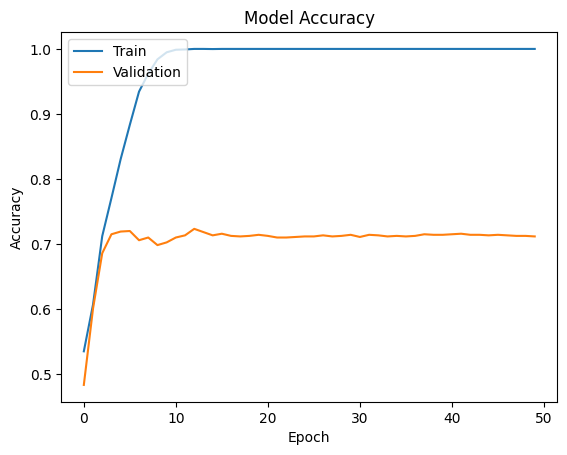

In [34]:
# Visualization of training and validation accuracy
plt.plot(history_woImanip.history['accuracy'])
plt.plot(history_woImanip.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

---

--- end of notebook : PREDICTION & TESTING On other notebook [02_model_Testing]('https://github.com/ghelanikirtan/Greyfeathers-task/blob/main/02_model_Testing.ipynb') ---